In [1]:
import os
import cv2
import shutil
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import xml.etree.ElementTree as xet
from sklearn.model_selection import train_test_split

In [2]:
import torch

print(f'{torch.cuda.is_available() = }')
print(f'{torch.cuda.device_count() = }')

torch.cuda.is_available() = True
torch.cuda.device_count() = 2


In [3]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.5/825.5 kB 14.8 MB/s eta 0:00:00a 0:00:01


In [4]:
!pip install -U ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 3.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.4/214.4 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 48.4 MB/s eta 0:00:0000:01
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.7
    Uninstalling widgetsnbextension-3.6.7:
      Successfully uninstalled widgetsnbextension-3.6.7
  Attempting uninstall: jupyterlab-widgets
    Found existing installation: jupyterlab-widgets 3.0.9
    Uninstalling jupyterlab-widgets-3.0.9:
      Successfully uninstalled jupyterlab-widgets-3.0.9
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


# Setting up the dataset paths

In [5]:
dataset_path = '/kaggle/input/car-plate-detection'

In [6]:
import re

def the_number_in_the_string(filename):
    """
    Extracts the first sequence of digits from the given filename string and returns it as an integer.
    If no digits are found, returns 0.

    Parameters:
    filename (str): The input string to search for digits.

    Returns:
    int: The first sequence of digits found in the input string, or 0 if no digits are found.
    """
    # Search for the first occurrence of one or more digits in the filename
    match = re.search(r'(\d+)', filename)
    
    # If a match is found, return the matched number as an integer
    if match:
        return int(match.group(0))
    # If no match is found, return 0
    else:
        return 0

# Example usage
print(the_number_in_the_string("file123.txt"))  # Output: 123
print(the_number_in_the_string("no_numbers_here"))  # Output: 0

123
0


# Formatting the XML File and creating DF

In [7]:
import os
import cv2
import pandas as pd
import xml.etree.ElementTree as xet
from glob import glob

# Initialize a dictionary to store labels and image information
labels_dict = dict(
    img_path=[], 
    xmin=[], 
    xmax=[], 
    ymin=[], 
    ymax=[], 
    img_w=[], 
    img_h=[]
)

# Get the list of XML files from the annotations directory
xml_files = glob(f'{dataset_path}/annotations/*.xml')

# Process each XML file, sorted by the numerical value in the filename
for filename in sorted(xml_files, key=the_number_in_the_string):
    # Parse the XML file
    info = xet.parse(filename)
    root = info.getroot()
    
    # Find the 'object' element in the XML and extract bounding box information
    member_object = root.find('object')
    labels_info = member_object.find('bndbox')
    xmin = int(labels_info.find('xmin').text)
    xmax = int(labels_info.find('xmax').text)
    ymin = int(labels_info.find('ymin').text)
    ymax = int(labels_info.find('ymax').text)
    
    # Get the image filename and construct the full path to the image
    img_name = root.find('filename').text
    img_path = os.path.join(dataset_path, 'images', img_name)

    # Append the extracted information to the respective lists in the dictionary
    labels_dict['img_path'].append(img_path)
    labels_dict['xmin'].append(xmin)
    labels_dict['xmax'].append(xmax)
    labels_dict['ymin'].append(ymin)
    labels_dict['ymax'].append(ymax)
    
    # Read the image to get its dimensions
    height, width, _ = cv2.imread(img_path).shape
    labels_dict['img_w'].append(width)
    labels_dict['img_h'].append(height)
    
# Convert the dictionary to a pandas DataFrame
alldata = pd.DataFrame(labels_dict)

# Display the DataFrame
alldata

,img_path,xmin,xmax,ymin,ymax,img_w,img_h
0,/kaggle/input/car-plate-detection/images/Cars0...,226,419,125,173,500,268
1,/kaggle/input/car-plate-detection/images/Cars1...,134,262,128,160,400,248
2,/kaggle/input/car-plate-detection/images/Cars2...,229,270,176,193,400,400
3,/kaggle/input/car-plate-detection/images/Cars3...,142,261,128,157,400,225
4,/kaggle/input/car-plate-detection/images/Cars4...,156,503,82,253,590,350
...,...,...,...,...,...,...,...
428,/kaggle/input/car-plate-detection/images/Cars4...,142,258,128,157,400,225
429,/kaggle/input/car-plate-detection/images/Cars4...,86,208,166,195,301,400
430,/kaggle/input/car-plate-detection/images/Cars4...,38,116,159,197,400,225
431,/kaggle/input/car-plate-detection/images/Cars4...,55,343,82,147,400,192


In [8]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
# Use 10% of the data for the test set
train, test = train_test_split(alldata, test_size=1/10, random_state=42)

# Split the training data further into training and validation sets
# Use 8/9 of the remaining data for the training set, resulting in an 80/10/10 split overall
train, val = train_test_split(train, train_size=8/9, random_state=42)

# Print the number of samples in each set
print(f'''
      len(train) = {len(train)}
      len(val) = {len(val)}
      len(test) = {len(test)}
''')



      len(train) = 345
      len(val) = 44
      len(test) = 44



In [9]:
import os
import shutil
import pandas as pd

# Remove the 'datasets' directory if it exists
if os.path.exists('datasets'):
    shutil.rmtree('datasets')

In [10]:
train

,img_path,xmin,xmax,ymin,ymax,img_w,img_h
124,/kaggle/input/car-plate-detection/images/Cars1...,305,320,256,267,400,267
315,/kaggle/input/car-plate-detection/images/Cars3...,12,385,98,181,400,300
282,/kaggle/input/car-plate-detection/images/Cars2...,37,319,145,203,350,263
236,/kaggle/input/car-plate-detection/images/Cars2...,223,250,106,119,400,176
112,/kaggle/input/car-plate-detection/images/Cars1...,49,164,135,191,240,400
...,...,...,...,...,...,...,...
110,/kaggle/input/car-plate-detection/images/Cars1...,286,328,133,159,400,267
255,/kaggle/input/car-plate-detection/images/Cars2...,116,273,156,188,400,267
292,/kaggle/input/car-plate-detection/images/Cars2...,91,137,187,208,400,267
54,/kaggle/input/car-plate-detection/images/Cars5...,148,257,61,118,400,300


In [11]:
def make_split_folder_in_yolo_format(split_name, split_df):
    """
    Creates a folder structure for a dataset split (train/val/test) in YOLO format.

    Parameters:
    split_name (str): The name of the split (e.g., 'train', 'val', 'test').
    split_df (pd.DataFrame): The DataFrame containing the data for the split.

    The function will create 'labels' and 'images' subdirectories under 'datasets/cars_license_plate/{split_name}',
    and save the corresponding labels and images in YOLO format.
    """
    labels_path = os.path.join('datasets', 'cars_license_plate_new', split_name, 'labels')
    images_path = os.path.join('datasets', 'cars_license_plate_new', split_name, 'images')

    # Create directories for labels and images
    os.makedirs(labels_path)
    os.makedirs(images_path)
    
    # Iterate over each row in the DataFrame
    for _, row in split_df.iterrows():
        img_name, img_extension = os.path.splitext(os.path.basename(row['img_path']))
        
        # Calculate YOLO format bounding box coordinates
        x_center = (row['xmin'] + row['xmax']) / 2 / row['img_w']
        y_center = (row['ymin'] + row['ymax']) / 2 / row['img_h']
        width = (row['xmax'] - row['xmin']) / row['img_w']
        height = (row['ymax'] - row['ymin']) / row['img_h']

        # Save the label in YOLO format
        label_path = os.path.join(labels_path, f'{img_name}.txt')
        with open(label_path, 'w') as file:
            file.write(f"0 {x_center:.4f} {y_center:.4f} {width:.4f} {height:.4f}\n")
            
        # Copy the image to the images directory
        shutil.copy(row['img_path'], os.path.join(images_path, img_name + img_extension))
    
    print(f"Created '{images_path}' and '{labels_path}'")

In [12]:
# Create YOLO format folders for train, validation, and test splits
make_split_folder_in_yolo_format("train", train)
make_split_folder_in_yolo_format("val", val)
make_split_folder_in_yolo_format("test", test)

Created 'datasets/cars_license_plate_new/train/images' and 'datasets/cars_license_plate_new/train/labels'
Created 'datasets/cars_license_plate_new/val/images' and 'datasets/cars_license_plate_new/val/labels'
Created 'datasets/cars_license_plate_new/test/images' and 'datasets/cars_license_plate_new/test/labels'


In [13]:
os.getcwd()

'/kaggle/working'

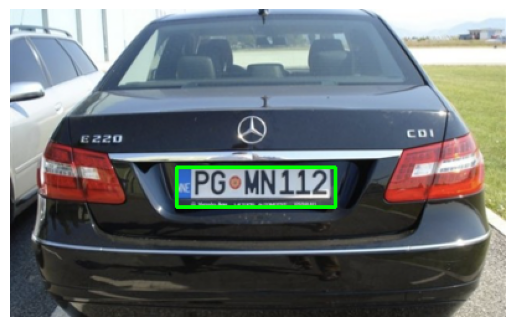

In [14]:
import os
import cv2
import matplotlib.pyplot as plt

# Directory paths
image_dir = 'datasets/cars_license_plate_new/train/images'
label_dir = 'datasets/cars_license_plate_new/train/labels'

# Get the first image file
image_files = sorted(os.listdir(image_dir))
first_image_file = image_files[0]

# Construct paths for the image and its corresponding label
image_path = os.path.join(image_dir, first_image_file)
label_path = os.path.join(label_dir, os.path.splitext(first_image_file)[0] + '.txt')

# Load the image using OpenCV
image = cv2.imread(image_path)
# Convert the image from BGR (OpenCV default) to RGB (matplotlib default)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Read the label file to get bounding box information
with open(label_path, 'r') as f:
    lines = f.readlines()

# Plot the bounding box on the image
for line in lines:
    # Parse the label file line to extract bounding box information
    class_id, x_center, y_center, width, height = map(float, line.strip().split())
    img_height, img_width, _ = image.shape

    # Convert YOLO format to bounding box format
    x_center *= img_width
    y_center *= img_height
    width *= img_width
    height *= img_height

    # Calculate the top-left and bottom-right coordinates of the bounding box
    x1 = int(x_center - width / 2)
    y1 = int(y_center - height / 2)
    x2 = int(x_center + width / 2)
    y2 = int(y_center + height / 2)

    # Draw the bounding box on the image using a green rectangle
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

# Display the image with bounding box using matplotlib
plt.imshow(image)
plt.axis('off')  # Hide the axis
plt.show()  # Display the image

In [15]:
# Define the content of the datasets.yaml file
datasets_yaml = '''
path: cars_license_plate_new

train: train/images
val: val/images
test: test/images

# number of classes
nc: 1

# class names
names: ['license_plate']
'''

# Write the content to the datasets.yaml file
with open('datasets.yaml', 'w') as file:
    file.write(datasets_yaml)

In [16]:
from ultralytics import YOLO
model = YOLO('yolov9s.pt')

100%|██████████| 14.7M/14.7M [00:00<00:00, 123MB/s] 


In [17]:
model.train(
    data='datasets.yaml',  # Path to the dataset configuration file
    epochs=100,            # Number of training epochs
    batch=16,              # Batch size
    device='cuda',         # Use GPU for training
    imgsz=320,             # Image size (width and height) for training
    cache=True             # Cache images for faster training
)

Ultralytics YOLOv8.2.66 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov9s.pt, data=datasets.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=320, save=True, save_period=-1, cache=True, device=cuda, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_wi

100%|██████████| 755k/755k [00:00<00:00, 14.1MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     31104  ultralytics.nn.modules.block.ELAN1           [64, 64, 64, 32]              
  3                  -1  1     73984  ultralytics.nn.modules.block.AConv           [64, 128]                     
  4                  -1  1    258432  ultralytics.nn.modules.block.RepNCSPELAN4    [128, 128, 128, 64, 3]        
  5                  -1  1    221568  ultralytics.nn.modules.block.AConv           [128, 192]                    
  6                  -1  1    579648  ultralytics.nn.modules.block.RepNCSPELAN4    [192, 192, 192, 96, 3]        
  7                  -1  1    442880  ultralytics

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...


100%|██████████| 6.25M/6.25M [00:00<00:00, 74.1MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/datasets/cars_license_plate_new/train/labels... 345 images, 0 backgrounds, 0 corrupt: 100%|██████████| 345/345 [00:00<00:00, 452.92it/s]

train: New cache created: /kaggle/working/datasets/cars_license_plate_new/train/labels.cache



train: Caching images (0.1GB RAM): 100%|██████████| 345/345 [00:01<00:00, 198.45it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/datasets/cars_license_plate_new/val/labels... 44 images, 0 backgrounds, 0 corrupt: 100%|██████████| 44/44 [00:00<00:00, 464.88it/s]

val: New cache created: /kaggle/working/datasets/cars_license_plate_new/val/labels.cache



val: Caching images (0.0GB RAM): 100%|██████████| 44/44 [00:00<00:00, 196.04it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 221 weight(decay=0.0), 228 weight(decay=0.0005), 227 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 320 train, 320 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      1.74G       1.87      2.614       1.45         17        320: 100%|██████████| 22/22 [00:08<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]

                   all         44         44      0.625      0.796      0.733      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      1.65G      1.489      1.214      1.235         22        320: 100%|██████████| 22/22 [00:04<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.07it/s]

                   all         44         44      0.679      0.636      0.601      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      1.67G      1.517      1.057      1.294         17        320: 100%|██████████| 22/22 [00:04<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.55it/s]

                   all         44         44      0.732      0.743      0.749      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      1.66G      1.538      1.111       1.28         19        320: 100%|██████████| 22/22 [00:04<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.30it/s]

                   all         44         44    0.00164     0.0909   0.000849   0.000315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      1.66G      1.506      1.041      1.287         14        320: 100%|██████████| 22/22 [00:04<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.25it/s]

                   all         44         44    0.00448       0.25    0.00296   0.000966



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      1.67G      1.584      1.064      1.365         17        320: 100%|██████████| 22/22 [00:04<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.64it/s]

                   all         44         44     0.0827      0.136     0.0376     0.0102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      1.66G      1.544      0.985      1.321         11        320: 100%|██████████| 22/22 [00:04<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.56it/s]

                   all         44         44      0.471      0.523      0.405      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      1.67G      1.415     0.8948      1.226         13        320: 100%|██████████| 22/22 [00:04<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.54it/s]

                   all         44         44    0.00424      0.273    0.00389    0.00155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      1.66G       1.39     0.8795      1.241         14        320: 100%|██████████| 22/22 [00:04<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.32it/s]

                   all         44         44     0.0384     0.0909     0.0071    0.00324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      1.67G      1.441      0.896      1.277         16        320: 100%|██████████| 22/22 [00:04<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.49it/s]

                   all         44         44      0.718      0.591      0.643      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      1.66G      1.439     0.8871       1.29         19        320: 100%|██████████| 22/22 [00:04<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.50it/s]

                   all         44         44      0.841       0.75      0.791      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      1.67G      1.429     0.8736      1.304         17        320: 100%|██████████| 22/22 [00:04<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.49it/s]

                   all         44         44      0.722       0.75       0.78      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      1.66G      1.388     0.8008      1.233         20        320: 100%|██████████| 22/22 [00:04<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.76it/s]

                   all         44         44      0.721      0.727      0.804      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      1.67G      1.334     0.8356      1.192         14        320: 100%|██████████| 22/22 [00:04<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.69it/s]

                   all         44         44      0.785      0.773      0.791      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      1.66G      1.305     0.8083      1.194         20        320: 100%|██████████| 22/22 [00:04<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.36it/s]

                   all         44         44      0.694      0.727       0.58      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      1.67G      1.351     0.8155      1.232         21        320: 100%|██████████| 22/22 [00:04<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.11it/s]

                   all         44         44      0.867      0.891      0.906        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      1.66G      1.306     0.7532      1.185         20        320: 100%|██████████| 22/22 [00:04<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.53it/s]

                   all         44         44      0.691      0.841      0.851      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      1.67G       1.28     0.7797      1.194         18        320: 100%|██████████| 22/22 [00:04<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.54it/s]

                   all         44         44      0.924      0.818      0.924      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      1.66G      1.242     0.7593      1.156         18        320: 100%|██████████| 22/22 [00:04<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.79it/s]

                   all         44         44      0.842      0.847      0.912      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      1.67G      1.235     0.7477      1.186         15        320: 100%|██████████| 22/22 [00:04<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.56it/s]

                   all         44         44      0.843      0.795      0.843      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      1.66G      1.244      0.731      1.189         20        320: 100%|██████████| 22/22 [00:04<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.71it/s]

                   all         44         44      0.855      0.803      0.825      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      1.67G       1.23     0.7208      1.152         19        320: 100%|██████████| 22/22 [00:04<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.43it/s]

                   all         44         44      0.869      0.909      0.924      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      1.66G      1.236     0.7218      1.156         22        320: 100%|██████████| 22/22 [00:04<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.94it/s]

                   all         44         44      0.921      0.795      0.874      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      1.67G       1.21      0.678      1.116         17        320: 100%|██████████| 22/22 [00:04<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.00it/s]

                   all         44         44      0.823      0.845      0.841      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      1.66G      1.162      0.689      1.133         26        320: 100%|██████████| 22/22 [00:04<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.10it/s]

                   all         44         44      0.893      0.795      0.874      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      1.67G      1.211     0.7014      1.132         18        320: 100%|██████████| 22/22 [00:04<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.95it/s]

                   all         44         44       0.81      0.773      0.859      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      1.66G      1.223     0.7022      1.134         18        320: 100%|██████████| 22/22 [00:04<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.37it/s]

                   all         44         44      0.897      0.788       0.83      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      1.67G      1.167     0.7043      1.138         16        320: 100%|██████████| 22/22 [00:04<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.61it/s]

                   all         44         44      0.853      0.922      0.914      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      1.66G      1.187      0.682      1.139         21        320: 100%|██████████| 22/22 [00:04<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.15it/s]

                   all         44         44      0.802      0.922      0.922      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      1.67G      1.123     0.6481      1.122         15        320: 100%|██████████| 22/22 [00:04<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.25it/s]

                   all         44         44      0.854      0.864       0.89      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      1.66G      1.099     0.6139      1.101         14        320: 100%|██████████| 22/22 [00:04<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.42it/s]

                   all         44         44      0.869      0.902      0.936      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      1.67G      1.115      0.633      1.095         17        320: 100%|██████████| 22/22 [00:04<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.63it/s]

                   all         44         44      0.877      0.864      0.911      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      1.66G      1.101     0.6313      1.107         18        320: 100%|██████████| 22/22 [00:04<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.39it/s]

                   all         44         44      0.816      0.864      0.865      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      1.67G      1.112     0.6266      1.124         18        320: 100%|██████████| 22/22 [00:04<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.57it/s]

                   all         44         44      0.862      0.853      0.855      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      1.66G      1.094     0.6019      1.078         16        320: 100%|██████████| 22/22 [00:04<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.24it/s]

                   all         44         44      0.915      0.864       0.91      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      1.67G      1.096     0.6193      1.074         18        320: 100%|██████████| 22/22 [00:04<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.68it/s]

                   all         44         44      0.946      0.795      0.847      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      1.66G      1.106     0.6264      1.084         15        320: 100%|██████████| 22/22 [00:04<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.58it/s]

                   all         44         44      0.791      0.818      0.859      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      1.67G       1.07     0.5924      1.069         16        320: 100%|██████████| 22/22 [00:04<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.34it/s]

                   all         44         44      0.851      0.864      0.888      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      1.66G       1.07     0.6072      1.083         12        320: 100%|██████████| 22/22 [00:04<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.68it/s]

                   all         44         44      0.863      0.841      0.911      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      1.67G      1.043     0.6044      1.058         19        320: 100%|██████████| 22/22 [00:04<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.59it/s]

                   all         44         44      0.931      0.773      0.882       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      1.66G     0.9719     0.5968      1.033         17        320: 100%|██████████| 22/22 [00:04<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.58it/s]

                   all         44         44      0.921      0.818      0.872      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      1.67G      1.008     0.5856      1.027         16        320: 100%|██████████| 22/22 [00:04<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.63it/s]

                   all         44         44      0.849      0.894      0.888      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      1.66G     0.9904     0.5823      1.051         13        320: 100%|██████████| 22/22 [00:04<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.46it/s]

                   all         44         44      0.907      0.886      0.883      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      1.67G     0.9972     0.5829      1.055         12        320: 100%|██████████| 22/22 [00:04<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.71it/s]

                   all         44         44      0.925      0.839      0.906      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      1.66G     0.9998     0.5704      1.029         21        320: 100%|██████████| 22/22 [00:04<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.19it/s]

                   all         44         44      0.847      0.886      0.884      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      1.67G     0.9483     0.5407      1.033         16        320: 100%|██████████| 22/22 [00:04<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.24it/s]

                   all         44         44      0.864      0.909       0.89      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      1.66G     0.9269       0.53      1.027         15        320: 100%|██████████| 22/22 [00:04<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.03it/s]

                   all         44         44      0.874      0.841      0.864      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      1.67G     0.9711      0.551      1.048         17        320: 100%|██████████| 22/22 [00:04<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.30it/s]

                   all         44         44      0.941      0.727      0.873      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      1.66G     0.9766     0.5527      1.058         20        320: 100%|██████████| 22/22 [00:04<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.55it/s]

                   all         44         44       0.83      0.909      0.901      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      1.67G     0.9076     0.5149      1.025         26        320: 100%|██████████| 22/22 [00:04<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.39it/s]

                   all         44         44      0.857      0.864      0.919      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      1.66G     0.9173     0.5306      1.005         13        320: 100%|██████████| 22/22 [00:04<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.41it/s]

                   all         44         44      0.784      0.932      0.929      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      1.67G     0.8816     0.5054       1.02         17        320: 100%|██████████| 22/22 [00:04<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.33it/s]

                   all         44         44      0.833      0.905      0.931      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      1.66G     0.8869     0.4997     0.9958         11        320: 100%|██████████| 22/22 [00:04<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.79it/s]

                   all         44         44      0.848      0.761      0.857      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      1.67G     0.9133     0.5074     0.9878         12        320: 100%|██████████| 22/22 [00:04<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.78it/s]

                   all         44         44      0.835      0.841       0.87      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      1.66G     0.9603      0.532      1.034         18        320: 100%|██████████| 22/22 [00:04<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.22it/s]

                   all         44         44       0.84      0.836      0.884      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      1.67G     0.9257      0.508      1.015         19        320: 100%|██████████| 22/22 [00:04<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.46it/s]

                   all         44         44      0.826       0.86       0.87      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      1.66G     0.9056     0.5054      1.021         18        320: 100%|██████████| 22/22 [00:04<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.59it/s]

                   all         44         44      0.861      0.841      0.906      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      1.67G     0.8637     0.4905      1.025         12        320: 100%|██████████| 22/22 [00:04<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.32it/s]

                   all         44         44      0.835      0.818      0.852      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      1.66G     0.8876     0.4918     0.9951         15        320: 100%|██████████| 22/22 [00:04<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.39it/s]

                   all         44         44      0.878      0.818      0.861      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      1.67G     0.8299     0.4668     0.9865         20        320: 100%|██████████| 22/22 [00:04<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.55it/s]

                   all         44         44      0.898      0.818      0.898      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      1.66G     0.8488     0.4861     0.9946         20        320: 100%|██████████| 22/22 [00:04<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.23it/s]

                   all         44         44      0.887      0.818      0.886      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      1.67G     0.8407     0.4882     0.9635         14        320: 100%|██████████| 22/22 [00:04<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.35it/s]

                   all         44         44      0.882      0.846      0.913      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      1.66G     0.8329     0.4605     0.9771         18        320: 100%|██████████| 22/22 [00:04<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.82it/s]

                   all         44         44      0.821      0.864      0.884      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      1.67G     0.8299     0.4782      1.012         13        320: 100%|██████████| 22/22 [00:04<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.61it/s]

                   all         44         44      0.821      0.886      0.882      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      1.66G     0.8219     0.4587     0.9924         16        320: 100%|██████████| 22/22 [00:04<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.65it/s]

                   all         44         44      0.817      0.932      0.908       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      1.67G     0.8538     0.4671      1.011         15        320: 100%|██████████| 22/22 [00:04<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.40it/s]

                   all         44         44      0.817      0.932       0.91      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      1.66G     0.8256      0.466     0.9893         17        320: 100%|██████████| 22/22 [00:04<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.22it/s]

                   all         44         44      0.863      0.818      0.882      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      1.67G     0.8095     0.4618     0.9871         14        320: 100%|██████████| 22/22 [00:04<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.37it/s]

                   all         44         44      0.828      0.877      0.893      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      1.66G     0.8243     0.4581     0.9817         18        320: 100%|██████████| 22/22 [00:04<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.15it/s]

                   all         44         44      0.903      0.886      0.895      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      1.67G     0.8207     0.4535     0.9845         23        320: 100%|██████████| 22/22 [00:04<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.75it/s]

                   all         44         44      0.922      0.805      0.879      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      1.66G     0.7724     0.4327     0.9547         13        320: 100%|██████████| 22/22 [00:04<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.43it/s]

                   all         44         44      0.803      0.928       0.86      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      1.67G     0.8433     0.4636     0.9882         18        320: 100%|██████████| 22/22 [00:04<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.37it/s]

                   all         44         44      0.847      0.841      0.872      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      1.66G     0.8205     0.4692     0.9872         18        320: 100%|██████████| 22/22 [00:04<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.07it/s]

                   all         44         44      0.842      0.848      0.889      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      1.67G     0.8032     0.4467     0.9768         15        320: 100%|██████████| 22/22 [00:04<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.58it/s]

                   all         44         44      0.816      0.905       0.91      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      1.66G     0.7743     0.4312       0.96         14        320: 100%|██████████| 22/22 [00:04<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.45it/s]

                   all         44         44      0.855      0.864      0.901      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      1.67G     0.7496     0.4523      0.967         20        320: 100%|██████████| 22/22 [00:04<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.75it/s]

                   all         44         44      0.863      0.818       0.88      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      1.66G     0.7185     0.4004      0.939         13        320: 100%|██████████| 22/22 [00:04<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.41it/s]

                   all         44         44      0.855      0.805       0.87      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      1.67G     0.7331     0.4104     0.9499         19        320: 100%|██████████| 22/22 [00:04<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.11it/s]

                   all         44         44      0.809      0.818      0.842      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      1.66G     0.7687     0.4287     0.9649         18        320: 100%|██████████| 22/22 [00:04<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.42it/s]

                   all         44         44      0.882      0.848      0.914      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      1.67G     0.7355     0.4239     0.9344         22        320: 100%|██████████| 22/22 [00:04<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.28it/s]

                   all         44         44      0.878      0.841      0.887      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      1.66G     0.7192     0.4076     0.9767         22        320: 100%|██████████| 22/22 [00:04<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.12it/s]

                   all         44         44      0.866      0.818      0.867      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      1.67G     0.7606      0.415     0.9599         15        320: 100%|██████████| 22/22 [00:04<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.51it/s]

                   all         44         44      0.795       0.88      0.898      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      1.66G     0.9266     0.4412      1.038          9        320: 100%|██████████| 22/22 [00:04<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.41it/s]

                   all         44         44      0.849      0.893      0.918       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      1.67G     0.9065     0.4498      1.011          8        320: 100%|██████████| 22/22 [00:04<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.80it/s]

                   all         44         44      0.814      0.932      0.919      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      1.66G       0.87     0.4211      1.042          9        320: 100%|██████████| 22/22 [00:04<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.39it/s]

                   all         44         44      0.819      0.932      0.921      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      1.67G     0.9004     0.4282       1.03          9        320: 100%|██████████| 22/22 [00:04<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.58it/s]

                   all         44         44      0.878      0.864      0.906      0.536



100 epochs completed in 0.196 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 15.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 15.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.2.66 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15095MiB)
YOLOv9s summary (fused): 486 layers, 7,167,475 parameters, 0 gradients, 26.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.00it/s]


                   all         44         44      0.842      0.845      0.889      0.557
Speed: 0.1ms preprocess, 2.7ms inference, 0.0ms loss, 9.0ms postprocess per image
Results saved to runs/detect/train


lr/pg0,▂▆███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
lr/pg1,▂▆███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
lr/pg2,▂▆███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
metrics/mAP50(B),▆▇▁▁▇▇██▇█▇██▇▇████████▇████████████████
metrics/mAP50-95(B),▆▅▁▁▆▆▇█▇▇▇██▇▇▇▇▇█▇▇█▇▇██▇███▇██▇██████
metrics/precision(B),▆▆▂▁▇▆▇█▇█▇▇▇▇█▇██▇▇▇▇▇▇█▇▇█▇▇▇█▇▇▇▇▇▇▇▇
metrics/recall(B),▇▆▁▂▆▆█▇▇▇▇██▇▇▇▇▇███▇▇▇▇█▇█▇█▇▇█▇█████▇
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,█▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▃▂▂▂


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7addb4198880>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

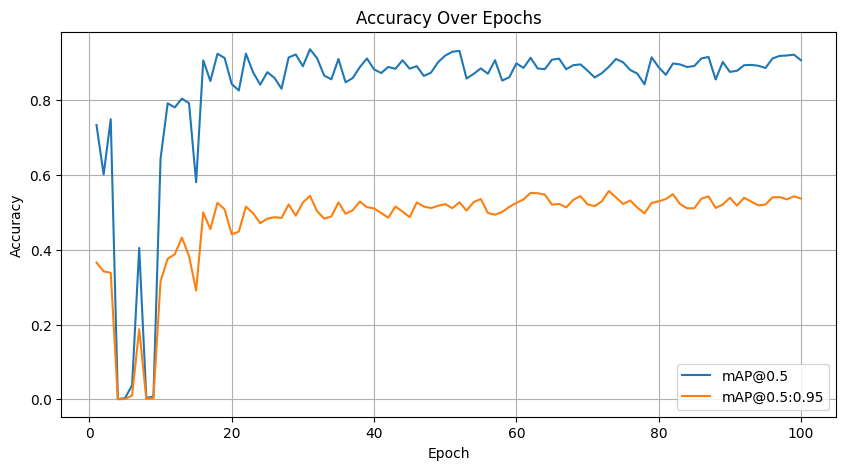

In [19]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob


# Find the most recent training log directory
log_dir = max(glob('runs/detect/train*'), key=the_number_in_the_string)

# Load the training results from the CSV file
results = pd.read_csv(os.path.join(log_dir, 'results.csv'))
results.columns = results.columns.str.strip()  # Remove any leading/trailing whitespace from column names

# Extract epochs and accuracy metrics
epochs = results.index + 1  # Epochs are zero-indexed, so add 1
mAP_0_5 = results['metrics/mAP50(B)']  # Mean Average Precision at IoU=0.5
mAP_0_5_0_95 = results['metrics/mAP50-95(B)']  # Mean Average Precision at IoU=0.5:0.95

# Plot the accuracy over epochs
plt.figure(figsize=(10, 5))
plt.plot(epochs, mAP_0_5, label='mAP@0.5')
plt.plot(epochs, mAP_0_5_0_95, label='mAP@0.5:0.95')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
# Save the trained model
model.save('best_license_plate_model.pt')

In [21]:
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO


def predict_and_plot(path_test_car):
    """
    Predicts and plots the bounding boxes on the given test image using the trained YOLO model.

    Parameters:
    path_test_car (str): Path to the test image file.
    """
    # Perform prediction on the test image using the model
    results = model.predict(path_test_car, device='cpu')

    # Load the image using OpenCV
    image = cv2.imread(path_test_car)
    # Convert the image from BGR (OpenCV default) to RGB (matplotlib default)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Extract the bounding boxes and labels from the results
    for result in results:
        for box in result.boxes:
            # Get the coordinates of the bounding box
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            # Get the confidence score of the prediction
            confidence = box.conf[0]

            # Draw the bounding box on the image
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            # Draw the confidence score near the bounding box
            cv2.putText(image, f'{confidence*100:.2f}%', (x1, y1 - 10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

    # Plot the image with bounding boxes
    plt.imshow(image)
    plt.axis('off')  # Hide the axis
    plt.show()  # Display the image


image 1/1 /kaggle/input/car-plate-detection/images/Cars425.png: 160x320 1 license_plate, 100.7ms
Speed: 1.2ms preprocess, 100.7ms inference, 8.0ms postprocess per image at shape (1, 3, 160, 320)


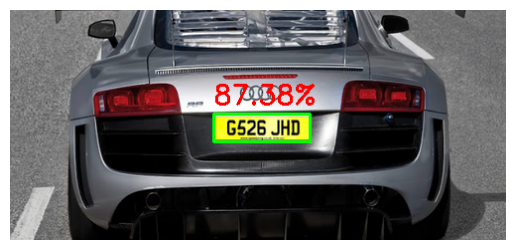

In [22]:
predict_and_plot(test.iloc[0].img_path)



image 1/1 /kaggle/input/car-plate-detection/images/Cars75.png: 224x320 (no detections), 106.9ms
Speed: 0.8ms preprocess, 106.9ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 320)


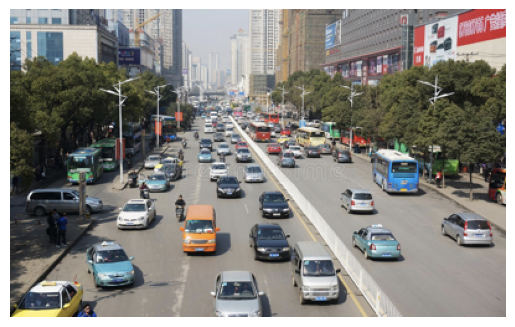

In [23]:
predict_and_plot(test.iloc[1].img_path)


image 1/1 /kaggle/input/car-plate-detection/images/Cars181.png: 320x192 1 license_plate, 94.6ms
Speed: 0.8ms preprocess, 94.6ms inference, 0.8ms postprocess per image at shape (1, 3, 320, 192)


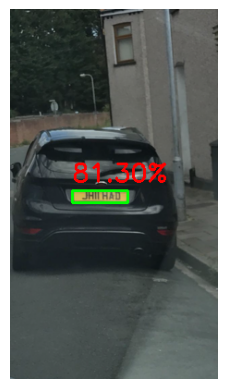

In [24]:
predict_and_plot(test.iloc[2].img_path)

In [25]:
!pip3 install pytesseract

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [26]:
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO
import pytesseract
from pytesseract import Output


def predict_and_plot(path_test_car):
    """
    Predicts and plots the bounding boxes on the given test image using the trained YOLO model.
    Also performs OCR on the detected bounding boxes to extract text.
    
    Parameters:
    path_test_car (str): Path to the test image file.
    """
    # Perform prediction on the test image using the model
    results = model.predict(path_test_car, device='cpu')

    # Load the image using OpenCV
    image = cv2.imread(path_test_car)
    # Convert the image from BGR (OpenCV default) to RGB (matplotlib default)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Extract the bounding boxes and labels from the results
    for result in results:
        for box in result.boxes:
            # Get the coordinates of the bounding box
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            # Get the confidence score of the prediction
            confidence = box.conf[0]

            # Draw the bounding box on the image
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            # Draw the confidence score near the bounding box
            cv2.putText(image, f'{confidence*100:.2f}%', (x1, y1 - 10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

            # Crop the bounding box from the image for OCR
            roi = image[y1:y2, x1:x2]

            # Perform OCR on the cropped image
            text = pytesseract.image_to_string(roi, config='--psm 6')
            print(f"Detected text: {text}")

    # Plot the image with bounding boxes
    plt.imshow(image)
    plt.axis('off')  # Hide the axis
    plt.show()  # Display the image


image 1/1 /kaggle/input/car-plate-detection/images/Cars425.png: 160x320 1 license_plate, 77.5ms
Speed: 0.8ms preprocess, 77.5ms inference, 0.8ms postprocess per image at shape (1, 3, 160, 320)
Detected text: G526 JHD



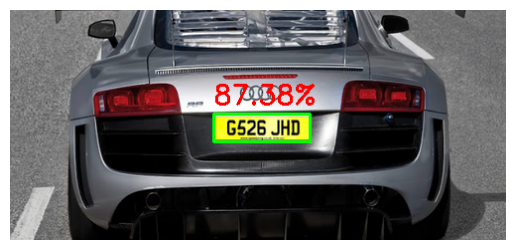

In [29]:
predict_and_plot(test.iloc[0].img_path)


image 1/1 /kaggle/input/car-plate-detection/images/Cars181.png: 320x192 1 license_plate, 87.7ms
Speed: 0.8ms preprocess, 87.7ms inference, 0.8ms postprocess per image at shape (1, 3, 320, 192)
Detected text: | JHA |



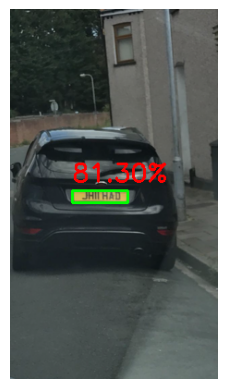

In [30]:
predict_and_plot(test.iloc[2].img_path)